# SIC PROJECT



Import the dependencies and set the device

In [5]:
#requirements and dependencies
#check if the requirements are installed
requirements = ["tensorflow", "numpy", "cv2", "tqdm", "matplotlib", "tensorboard", "tensorflow_hub", "sklearn"]
#if not, quit
for requirement in requirements:
    try:
        __import__(requirement)
    except ImportError:
        print("one or more requirements are not installed")
        print("please install the requirements in the requirements.txt file")
        print("you can do this by running the following command in the terminal:")
        print("pip install -r requirements.txt")
        raise ImportError("Requirement not installed: {}".format(requirement))

print("All requirements are installed, you are good to go!")

All requirements are installed, you are good to go!


In [6]:
#import packages
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tqdm
import datetime
from sklearn.metrics import confusion_matrix, classification_report


import tensorboard
%load_ext tensorboard
print("success")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
success


In [3]:
#check metal gpu
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()

/device:GPU:0
Num GPUs Available:  1


2023-08-04 09:39:52.656813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-04 09:39:52.656838: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-04 09:39:52.656841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-04 09:39:52.657024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-04 09:39:52.657052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Exploring and Processing

* Reading, processing, and augmenting all done by `ImageDataGenerator`

**Rapid EDA**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
datagen=ImageDataGenerator()

In [6]:
train_ds=datagen.flow_from_directory('data/train')

Found 2295 images belonging to 3 classes.


In [7]:
train_ds.class_indices

{'Fire': 0, 'Neutral': 1, 'Smoke': 2}

In [8]:
imgs,labels=train_ds.next()

C:\Users\Laqla\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


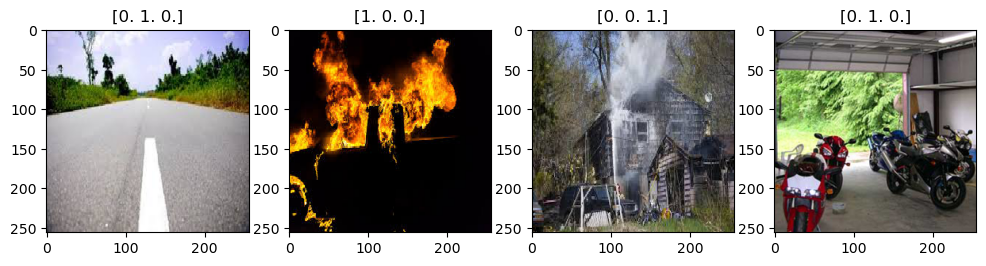

In [9]:
fig,ax=plt.subplots(1,4,figsize=(12,9))
for i in range(4):
    ax[i].imshow(imgs[i].astype('uint8'))    
    ax[i].set_title(labels[i])


**Processing and Augmenting Data**

In [10]:
#only augmenting the training dataset
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 width_shift_range=10.0,
                                 height_shift_range=10.0,
                                 shear_range=10,
                                 zoom_range=0.1,
                                 vertical_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)



train_ds=train_datagen.flow_from_directory('data/train',target_size=(224,224))
val_ds=val_datagen.flow_from_directory('data/val',target_size=(224,224))
test_ds=val_datagen.flow_from_directory('data/test',target_size=(224,224))

Found 2295 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


**Note:** The code below are needless, its prefered to remove it.

In [11]:
'''
#load data
def load_data(path, IMG_SIZE=224):
    """
    Load image data from directory, resize and return it after converting it.
    return tuple `(images, labels)`.
    """
    categories = os.listdir(path)
    data = []
    labels = []
    for category in tqdm.tqdm(categories):
        folder_path = os.path.join(path, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(categories.index(category))

    return np.array(data), tf.keras.utils.to_categorical(labels)
'''

'\n#load data\ndef load_data(path, IMG_SIZE=224):\n    """\n    Load image data from directory, resize and return it after converting it.\n    return tuple `(images, labels)`.\n    """\n    categories = os.listdir(path)\n    data = []\n    labels = []\n    for category in tqdm.tqdm(categories):\n        folder_path = os.path.join(path, category)\n\n        for img_name in os.listdir(folder_path):\n            img_path = os.path.join(folder_path, img_name)\n            img = cv2.imread(img_path)\n            if img is not None:\n                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))\n                data.append(img)\n                labels.append(categories.index(category))\n\n    return np.array(data), tf.keras.utils.to_categorical(labels)\n'

# Models building

In [18]:
#built from scratch model
def get_builtFromScartchModel(IMG_SIZE = 224, NUM_CLASSES = 3, dropout_rate=0,lr=0.001):
    
    #model architecture
    model = tf.keras.models.Sequential([

       tf.keras.layers.Conv2D(
           64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Conv2D(
           128, (3, 3), activation="relu"),
       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
       tf.keras.layers.Dropout(dropout_rate),

       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(128, activation="relu"),
       tf.keras.layers.Dropout(dropout_rate),
       tf.keras.layers.Dense(128, activation="relu"),
       tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

    ])

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )
    #get model summary
    model.summary()
    
    return model

In [13]:
def get_trained_model(url, inputShape=(224, 224, 3), trainModel=True,lr=0.0001):
    "takes in the url of the tensorflow_hub  model and the input shape and the train option, returns the trained model attached to a classification head"
    feature_extractor_layer = hub.KerasLayer(
        url,
        input_shape = inputShape,
        trainable=trainModel
        )

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(3, activation="softmax") #smoke, normal, fire
        ])
    
    #compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    #display the model summary
    model.summary()
    
    return model

In [14]:
def evaluate(model, fitHistory, historyEval, test_data, test_labels):
    """
    Prints the metrics while fitting and testing the model and prints the confusion matrix.
    
    Args:
        model: A Keras model.
        fitHistory: A Keras History object returned by the `fit` method.
        predictHistory: The output of the `evaluate` method.
    """
    for i in range(len(model.metrics_names)):
        print(model.metrics_names[i] + ":\n"
               + "  while fitting: " + str(fitHistory.history[model.metrics_names[i]][-1]) + "\n"
               + "  while testing: " + str(historyEval[i]))
        
    print("-" * 50 + "\n")
    # print the cunfusion matrix #TODO: make it work for multiclass
    predictions = model.predict(test_data)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(test_labels, axis=1)
    print("-" * 50 + "\n")
    print("Confusion matrix:\n" + str(confusion_matrix(test_labels, predictions)))
    

# Train & Hyperparameter tuning

**1.0 Build multiple `FromScratch Model` with different hyperparameters**

In [19]:
#load model
model = get_builtFromScartchModel()

#some parameters
EPOCHS = 10
IMG_SIZE = 224
BATCH_SIZE = 100

#for tensorboard
log_dir = "logs/fit/" + str(len(os.listdir('logs/fit')) + 1) if os.path.exists('logs/fit') else "logs/fit/1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,  histogram_freq=1)

#split the data into validation and train %20 validation %80 train
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
#train and validate the model
historyFit = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback])
#evaluate the model
#historyEval = model.evaluate(test_ds, callbacks=[tensorboard_callback]) #evaluating on test_ds done at the end

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 373248)           

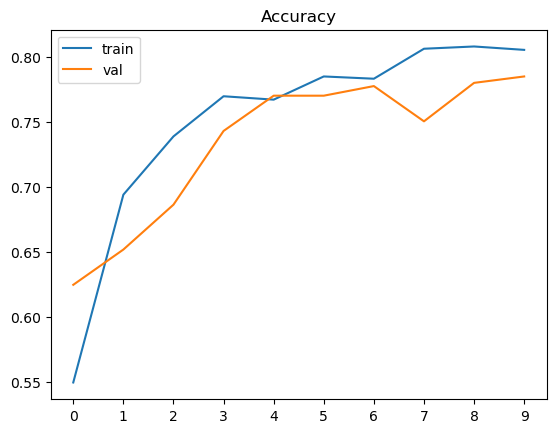

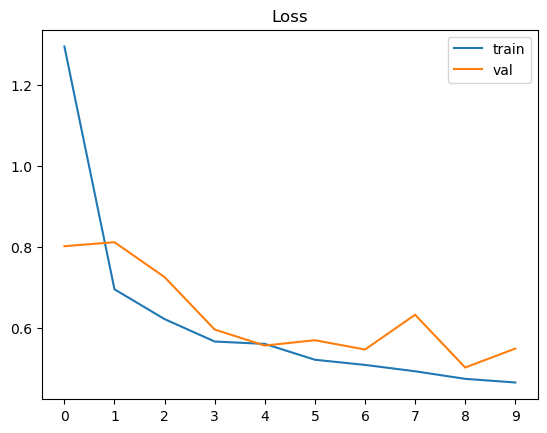

In [31]:
plt.plot(historyFit.history['categorical_accuracy'], label='train')
plt.plot(historyFit.history['val_categorical_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(historyFit.history['loss'], label='train')
plt.plot(historyFit.history['val_loss'], label='val')
plt.xticks(np.arange(10))
plt.title('Loss')
plt.legend()
plt.show()

**1.1 Search for Best Learning rate**

In [28]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:

    model = get_builtFromScartchModel(lr=lr)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[lr] = history.history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 54, 54, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 373248)           

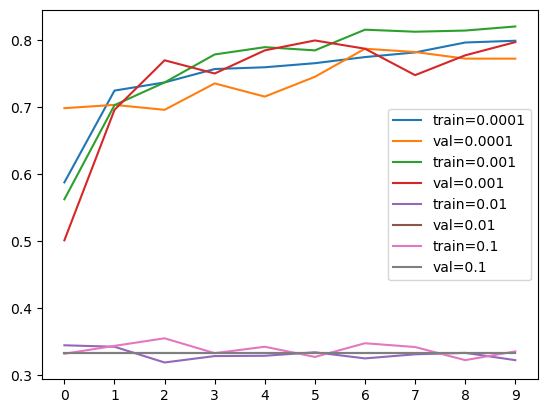

In [33]:
for lr, hist in scores.items():
    plt.plot(hist['categorical_accuracy'], label=(f'train={lr}'))
    plt.plot(hist['val_categorical_accuracy'], label=(f'val={lr}'))

plt.xticks(np.arange(10))
plt.legend();

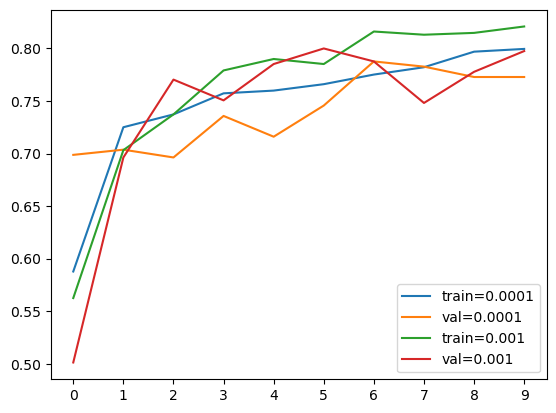

In [39]:
#remove poor scores to see better 
del scores[0.1]
del scores[0.01]

for lr, hist in scores.items():
        plt.plot(hist['categorical_accuracy'], label=(f'train={lr}'))
        plt.plot(hist['val_categorical_accuracy'], label=(f'val={lr}'))

plt.xticks(np.arange(10))
plt.legend();

**1.2 Search for best dropout rate**

In [41]:
learning_rate=0.001 #best lr so far
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:

    model = get_builtFromScartchModel(lr=learning_rate,dropout_rate=droprate)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[droprate] = history.history

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 54, 54, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 54, 54, 128)       0         
                                                                 
 flatten_7 (Flatten)         (None, 373248)           

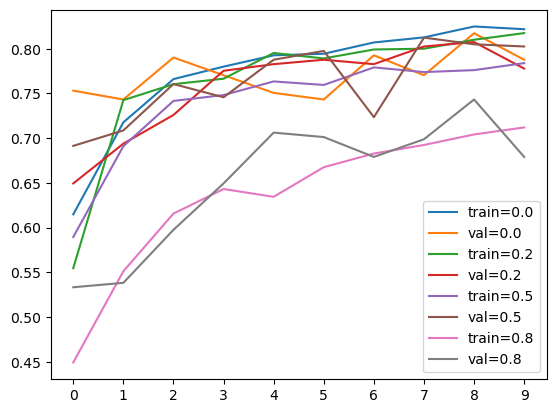

In [42]:
for droprate, hist in scores.items():
    plt.plot(hist['categorical_accuracy'], label=(f'train={droprate}'))
    plt.plot(hist['val_categorical_accuracy'], label=(f'val={droprate}'))

plt.xticks(np.arange(10))
plt.legend();

In [72]:
#del scores[0.8] #poor performance

colors=['red','blue','green']

for i,(droprate, hist) in enumerate(scores.items()):
    plt.plot(hist['categorical_accuracy'], label=(f'train={droprate}'), color=colors[i])
    plt.plot(hist['val_categorical_accuracy'],linestyle='dashed', label=(f'val={droprate}'), color=colors[i])

plt.xticks(np.arange(10))
plt.legend()
plt.show()

***Best Hyperparameters so far:***
- learning_rate = 0.001
- droprate = 0.2 (I might try 0.1 later)

**2.0 Build multiple `Pre-trained Model (EfficientNetv2)` with different hyperparameters**

> Not Done yet 

In [19]:
# Load the EfficientNetV2 pre-trained model from TensorFlow Hub, recommended input size is 240x240 pixels
module_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2"
model = get_trained_model(module_url)

#load data
#train_data, train_labels = load_data('data/train', 240)
#test_data, test_labels = load_data('data/test', 240)

#split data, 20% for validation
#train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

#for tensorboard
log_dir = "logs/fit/" + str(len(os.listdir('logs/eval')) + 1) if os.path.exists('logs/eval') else "logs/eval/1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,  histogram_freq=1)

#some parameters
EPOCHS = 10
BATCH_SIZE = 32

with tf.device('/device:GPU:0'):
    historyFit = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[tensorboard_callback], batch_size=BATCH_SIZE)
#    historyEval = model.evaluate(test_data, test_labels) evaluate on test_ds at the end

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1000)              8212124   
                                                                 
 dense_7 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 8215127 (31.34 MB)
Trainable params: 8144055 (31.07 MB)
Non-trainable params: 71072 (277.62 KB)
_________________________________________________________________
Epoch 1/10
72/72 [==============================] - 406s 6s/step - loss: 0.4093 - categorical_accuracy: 0.8370 - val_loss: 0.1542 - val_categorical_accuracy: 0.9556
Epoch 2/10
72/72 [==============================] - 468s 6s/step - loss: 0.0988 - categorical_accuracy: 0.9651 - val_loss: 0.1175 - val_categorical_accuracy: 0.9679
Epoch 3/10
72/72 [==============================] - 388s 5s/step - loss: 0.0

loss:
  while fitting: 0.008682509884238243
  while testing: 0.2407701164484024
categorical_accuracy:
  while fitting: 0.9978203773498535
  while testing: 0.9366666674613953
--------------------------------------------------

10/10 [==============================] - 6s 629ms/step
--------------------------------------------------

Confusion matrix:
[[92  1  7]
 [ 3 96  1]
 [ 5  2 93]]
['Fire', 'Neutral', 'Smoke']


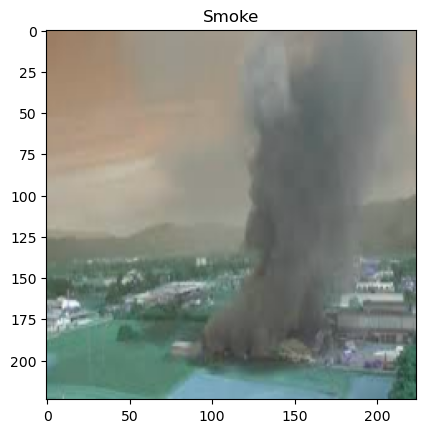

1/1 [==============================] - 0s 83ms/step
[[1.2429438e-04 7.1387863e-06 9.9986851e-01]]


In [22]:
evaluate(model, historyFit, historyEval, test_data, test_labels)
##Random image prediction
# Assuming val_data and val_label are already defined
random_index = np.random.randint(len(test_data))
random_image = test_data[random_index]
random_label = test_labels[random_index]
class_vector = np.argmax(random_label)

categories = os.listdir('data/test')
print(categories)

# Display the image and its label
plt.imshow(random_image)
plt.title(categories[class_vector])
plt.show()
#predict the image
prediction = model.predict(random_image.reshape((-1, 224, 224,3)))
print(prediction)

In [ ]:
#lunch tensorboard to plot the results and the graphs
%tensorboard --logdir logs --port=6910